In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from BFM.MCMC_LH import Gibbs_sampling
from BFM.VI import NGVI

In [2]:
device1 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
P = 100
K = 15
N = 100



In [4]:
B_0 = np.random.randn(P,K)
sigma2_0 = np.diag(np.ones(P))
cov_0 = B_0 @ B_0.T + sigma2_0


In [5]:
X = np.random.multivariate_normal(np.zeros(P), cov_0, N)

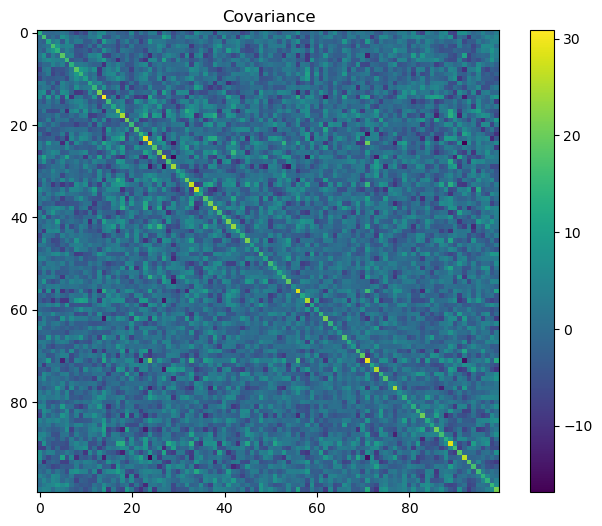

In [6]:
plt.figure(figsize=(8, 6))
plt.imshow(cov_0)
plt.colorbar()
plt.title("Covariance")
plt.show()

In [ ]:
B_sample, sigma2_sample = Gibbs_sampling(torch.from_numpy(X).to(device1), a = 1, b = 1, c = 0.05, r = 30)

In [7]:
mu, Precision, np_sigma, v = NGVI(X, device = device1, a = 1, b = 100, c = 0.05, r = 30)

100%|██████████| 50/50 [00:05<00:00,  8.94it/s]


In [ ]:
A = torch.einsum('bij,bjk->bik',B_sample, B_sample.transpose(1,2))
for i in range(10000):
    A[i] = A[i] + torch.diag(sigma2_sample[i])

In [8]:
B = mu @ mu.T + (v / (v-2)) * torch.diag(torch.vmap(torch.trace)(torch.linalg.inv(Precision))) + torch.diag(np_sigma / (0.5 * N))

In [ ]:
A_mean = A.mean(0)

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(A_mean)
plt.colorbar()
plt.title("Covariance")
plt.show()

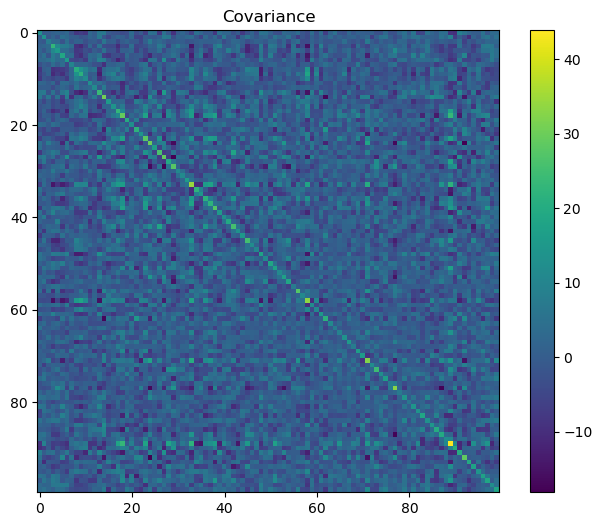

In [9]:
plt.figure(figsize=(8, 6))
plt.imshow(B.to('cpu'))
plt.colorbar()
plt.title("Covariance")
plt.show()

In [10]:
v

tensor([1009.9931, 1000.7876,  998.9206,  998.3170, 1000.8090, 1004.8938,
         993.2364,  993.9359,  992.3746,  990.9348, 1003.6284,  997.8586,
        1009.5015, 1004.0582, 1001.5102, 1009.7991, 1003.8290,  997.5079,
         997.1141, 1002.5210,  987.6165,  996.0347,  998.6911, 1001.5454,
         998.7311,  998.5790,  995.0072,  998.2610, 1001.5643,  996.1916,
         988.8555,  985.5313, 1005.7696,  998.9067,  986.4268,  996.8061,
         993.7835, 1001.7196, 1003.5069, 1005.7768,  996.9900,  997.7828,
         996.3430,  991.0531,  990.7280,  997.2699, 1001.5631, 1008.3044,
         998.0694,  990.0727, 1001.9740, 1001.1097,  999.6151, 1008.2932,
        1001.5982, 1000.6836,  996.0573,  995.1716,  995.0239, 1003.6666,
        1007.8807, 1009.3998, 1002.2316,  990.5105, 1002.9665,  994.5295,
         994.4084,  990.4063,  991.8792,  990.4048, 1003.1760,  987.5571,
         996.7751, 1002.0867,  999.9770, 1003.1397,  999.0833, 1000.4420,
        1005.2977, 1006.9047,  993.426

In [ ]:
cov_true = torch.from_numpy(cov_0)

In [ ]:
(cov_true - A_mean).abs().sum()/P**2

In [ ]:
(cov_true - A_mean).pow(2).sum()/P**2

In [ ]:
B_mean = B_sample.mean(0)

In [ ]:
for i in range(30):
    
    print(B_mean[:,i].abs().sum())

In [ ]:
(cov_true - B.to('cpu')).square().sum()/ P**2

In [ ]:
(cov_true - B.to('cpu')).abs().sum() / P**2

In [ ]:
for i in range(30):

    print(mu[:,i].abs().sum())